## Imports and helper functions

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
mat_contents = scipy.io.loadmat('mnist', appendmat=True)

In [2]:
def plot_confusion_matrix(conf_matrix, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show

In [3]:
def normalize_data(data):
    return data / 255.0

In [4]:
def identity(x):
    return x

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)
    
def sin(x):
    return np.sin(x)

In [5]:
"""
train_x: (60000, 785) -> (60000, 1000)
"""
def feature_map(train_x, L=1000, function=identity, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    normalize_data(train_x)
    
    train_x = np.column_stack((train_x, np.ones(len(train_x)))) # shape (60000, 785)

    W = np.random.normal(0, 1, (train_x.shape[1], L)) # W has shape (785, 1000)

    product = np.dot(train_x, W)
    
    product = function(product) # shape (60000, 1000)
    
    return product

In [6]:
"""
train_x: (60000, 784)
train_y: (1, 60000)
a, b: integers to train on
"""
def ovo_get_weights(train_x, train_y, a, b):
    # Preprocess train data
    train_y = train_y.T
    mask = np.where((train_y == a) | (train_y == b))[0]
    masked_x = train_x[mask]
    masked_y = train_y[mask]

    masked_x = np.column_stack((masked_x, np.ones(len(masked_x))))
    masked_y = np.where(masked_y == a, 1, -1).astype('int8')
    
    # Calculate weights
    pinv = np.linalg.pinv(masked_x)                                 # pinv: (785, n) 
    return np.dot(pinv, masked_y)                                # weights: (785, 1)

def new_ovo_get_weights(train_x, train_y, a, b):
    # Preprocess train data
    mask = np.where((train_y.T == a) | (train_y.T == b))[0]
    masked_x = train_x[mask]
    masked_y = np.where(train_y.T[mask] == a, 1, -1).astype('int8')

    # Combine stacking and adding bias term in a single step
    masked_x = np.column_stack((masked_x, np.ones(len(masked_x))))

    # Calculate weights
    return np.dot(np.linalg.pinv(masked_x), masked_y)

In [7]:
"""
weights: (785, 1)
test_x: (60000, 784)
test_y: (1, 60000)
a, b: integers to train on
"""
def ovo_get_preds(weights, test_x, test_y, a, b):
    # Preprocess test data
    test_y = test_y.T                                              # test_y: (1, 10000) to (10000, 1)
    normalize_data(test_x)
    test_x = np.column_stack((test_x, np.ones(len(test_x))))       # test_x: (10000, 785)

    # Calculate predictions
    ovo_preds = np.dot(test_x, weights)                                # preds: (10000, 1)
    ovo_preds = ovo_preds[:, 0]                                            
    ovo_preds = np.where(ovo_preds >= 0, 1, -1).astype('int8')             

    return ovo_preds

In [8]:
"""
train_x: (60000, 784)
train_y: (1, 60000)
test_x: (10000, 1)
test_y: (1, 60000)
"""
def ovo_classifier(train_x, train_y, test_x, test_y):
    
    votes = np.zeros((len(test_x), 10), dtype=int)
    
    pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]

    for (i, j) in tqdm(pairs):
        ovo_preds = ovo_get_preds(
                ovo_get_weights(train_x, train_y, i, j),
                test_x, 
                test_y, 
                i, j)

        # For every pair, increment the vote of a certain class in votes
        for k in range(len(ovo_preds)):
            if ovo_preds[k] == 1:
                votes[k][i] += 1
            elif ovo_preds[k] == -1:
                votes[k][j] += 1
    
    return np.argmax(votes, axis=1)

In [9]:
"""
preds: (10000, 1)
test_y: (1, 10000)
"""
def eval_ovo_classifier(ovo_preds, test_y, title='Confusion Matrix'):
    # Plot a confusion matrix
    conf_matrix = [[0 for _ in range(10)] for _ in range(10)]    
    for i in range(len(test_y[0])):
        conf_matrix[test_y[0][i]][ovo_preds[i]] += 1
    conf_matrix = np.array(conf_matrix)
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    plot_confusion_matrix(conf_matrix, class_names, title)

    # Find the error rate
    correct = 0
    for i in range(10):
        for j in range(10):
            if i == j:
                correct += conf_matrix[i][j]
    acc = 100 * correct/10000
    print("Accuracy: {:.2f}%".format(acc, 2))
    print("Error rate: {:.2f}%".format(100 - acc, 2))

In [10]:
def eval_features(preds, test_y):
    count = 0
    for i in range(len(test_y[0])):
        if test_y[0][i] == preds[i]:
            count += 1

    return 100 - (100 * count / len(test_y[0]))

def vary_L(train_x, train_y, test_x, test_y, L, function=identity, seed=None):
    if seed is not None:
        np.random.seed(seed)

    percentage_array = [0 for _ in range(len(L))]
    
    for i in range(len(L)):
        
        preds = ovo_classifier(
            feature_map(train_x, L[i], function, seed=seed),
            train_y, 
            feature_map(test_x, L[i], function, seed=seed),
            test_y)

        percentage_array[i] = eval_features(preds, test_y)
    
    return percentage_array
    

In [11]:
train_x = np.array(mat_contents['trainX'])
train_y = np.array(mat_contents['trainY'])
test_x = np.array(mat_contents['testX'])
test_y = np.array(mat_contents['testY'])

In [12]:
def plot_L_versus_error(L, errors, title="Percent Error Versus L"):
    plt.plot(L, errors, marker='o', linestyle='-', color='b', label='Percentages')
    plt.xlabel('L')
    plt.ylabel('Error')
    plt.title(title)

    # Add labels for each point
    for i, txt in enumerate(errors):
        plt.text(L[i], errors[i], f'{txt:.2f}%', ha='left', va='bottom')

    plt.show()

In [13]:
# plot_L_versus_error(L, preds, title="Percent Error Versus L (Identity Function)")

In [14]:
# L = [250, 500, 750, 1000]
# preds = vary_L(train_x, train_y, test_x, test_y, L, function=identity)

In [15]:
# plot_L_versus_error(L, preds, title="Percent Error Versus L (Identity Function)")

In [16]:
# L = [700, 750, 800, 850, 900, 950, 1000]
# preds = vary_L(train_x, train_y, test_x, test_y, L, function=identity)
# plot_L_versus_error(L, preds, title="Percent Error Versus L (Identity Function)")

In [17]:
# L = [800, 900, 1000, 1100, 1200]
# preds = vary_L(train_x, train_y, test_x, test_y, L, function=identity)
# plot_L_versus_error(L, preds, title="Percent Error Versus L (Identity Function)")

In [18]:
# L = [800, 900, 1000, 1100, 1200]
# preds = vary_L(train_x, train_y, test_x, test_y, L, function=relu, seed=1)
# plot_L_versus_error(L, preds, title="Percent Error Versus L (ReLU Function)")

100%|█| 45/45 [00:54<00:00,  1.2
100%|█| 45/45 [01:09<00:00,  1.5
100%|█| 45/45 [01:27<00:00,  1.9
100%|█| 45/45 [01:45<00:00,  2.3
100%|█| 45/45 [02:05<00:00,  2.7
100%|█| 45/45 [02:35<00:00,  3.4
100%|█| 45/45 [03:00<00:00,  4.0
100%|█| 45/45 [03:15<00:00,  4.3
100%|█| 45/45 [03:59<00:00,  5.3
100%|█| 45/45 [04:21<00:00,  5.8
100%|█| 45/45 [05:07<00:00,  6.8


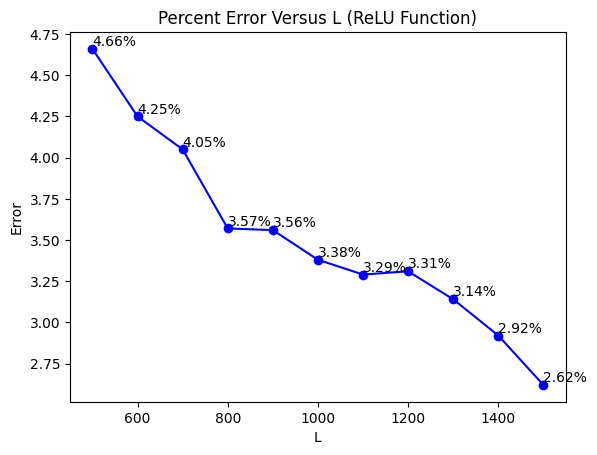

In [19]:
L = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
relu_preds = vary_L(train_x, train_y, test_x, test_y, L, function=relu, seed=1)
plot_L_versus_error(L, relu_preds, title="Percent Error Versus L (ReLU Function)")

100%|█| 45/45 [00:54<00:00,  1.2
100%|█| 45/45 [01:07<00:00,  1.5
100%|█| 45/45 [01:25<00:00,  1.8
100%|█| 45/45 [01:40<00:00,  2.2
100%|█| 45/45 [01:57<00:00,  2.6
100%|█| 45/45 [02:15<00:00,  3.0
100%|█| 45/45 [02:38<00:00,  3.5
100%|█| 45/45 [03:00<00:00,  4.0
100%|█| 45/45 [03:23<00:00,  4.5
100%|█| 45/45 [03:50<00:00,  5.1
100%|█| 45/45 [04:35<00:00,  6.1


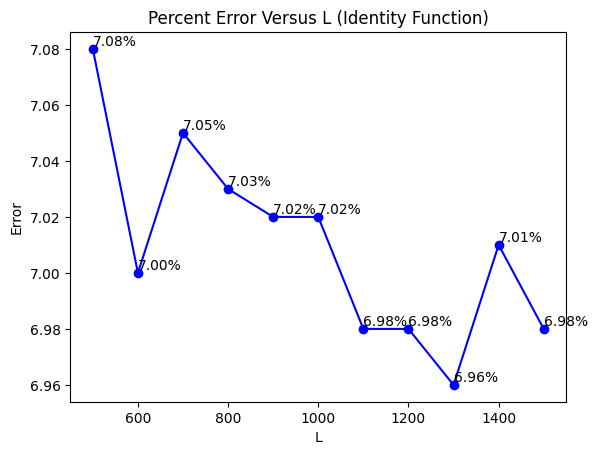

In [20]:
L = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
id_preds = vary_L(train_x, train_y, test_x, test_y, L, function=identity, seed=1)
plot_L_versus_error(L, id_preds, title="Percent Error Versus L (Identity Function)")

100%|█| 45/45 [01:00<00:00,  1.3
100%|█| 45/45 [01:19<00:00,  1.7
100%|█| 45/45 [01:31<00:00,  2.0
100%|█| 45/45 [01:51<00:00,  2.4
100%|█| 45/45 [02:17<00:00,  3.0
100%|█| 45/45 [02:53<00:00,  3.8
100%|█| 45/45 [03:25<00:
100%|█| 45/45 [03:41<00:
100%|█| 45/45 [03:58<00:
100%|█| 45/45 [04:40<00:
100%|█| 45/45 [05:10<00:


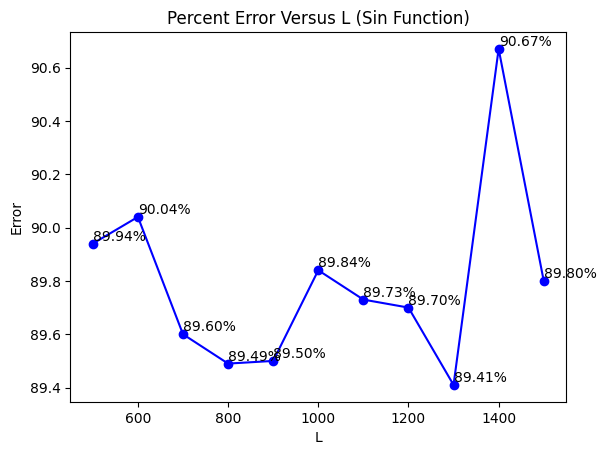

In [21]:
L = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
sin_preds = vary_L(train_x, train_y, test_x, test_y, L, function=sin, seed=1)
plot_L_versus_error(L, sin_preds, title="Percent Error Versus L (Sin Function)")

/var/folders/sk/m_1xv2y17xx96_8k07vtlgz80000gn/T/ipykernel_42977/2628440577.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|█| 45/45 [00:54<00:
100%|█| 45/45 [01:10<00:
100%|█| 45/45 [01:29<00:
100%|█| 45/45 [01:45<00:
100%|█| 45/45 [02:07<00:
100%|█| 45/45 [02:28<00:
100%|█| 45/45 [02:50<00:
100%|█| 45/45 [04:51<00:
100%|█| 45/45 [12:05<00:
100%|█| 45/45 [07:20<00:
100%|█| 45/45 [05:03<00:


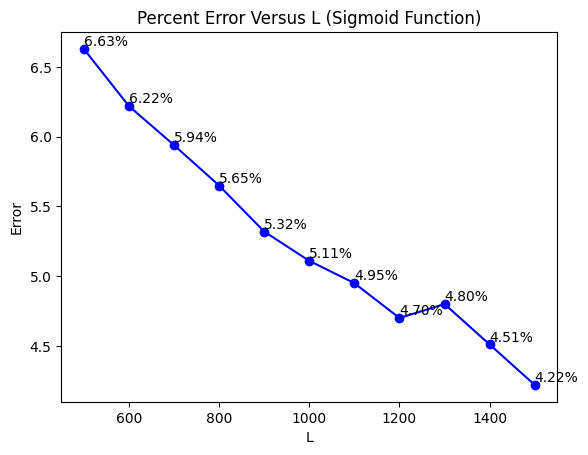

In [22]:
L = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
sig_preds = vary_L(train_x, train_y, test_x, test_y, L, function=sigmoid, seed=1)
plot_L_versus_error(L, sig_preds, title="Percent Error Versus L (Sigmoid Function)")